In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [43]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip

--2020-12-25 04:42:41--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  8.46MB/s    in 9.7s    

2020-12-25 04:42:51 (7.74 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]



In [44]:
!unzip apple2orange.zip

Archive:  apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflating: apple2orange/trainA/n07740461_2918.jpg  
  inflating: apple2orange/trainA/n07740461_1213.jpg  
  inflating: apple2orange/trainA/n07740461_2476.jpg  
  inflating: apple2orange/trainA/n07740461_13596.jpg  
  inflating: apple2orange/trainA/n07740461_4093.jpg  
  inflating: apple2orange/trainA/n07740461_14738.jpg  
  inflating: apple2orange/trainA/n07740461_6477.jpg  
  inflating: apple2orange/trainA/n07740461_11356.jpg  
  inflating: apple2orange/trainA/n07740461_7594.jpg  
  inflating: apple2orange/trainA/n07740461_5119.jpg  
  inflating: apple2orange/trainA/n07740461_104

In [3]:
import glob
train = glob.glob('apple2orange/trainA/*.jpg') + glob.glob('apple2orange/trainB/*.jpg')
test = glob.glob('apple2orange/testA/*.jpg') + glob.glob('apple2orange/testB/*.jpg')
len(train), len(test)

(2014, 514)

Low quality Samples


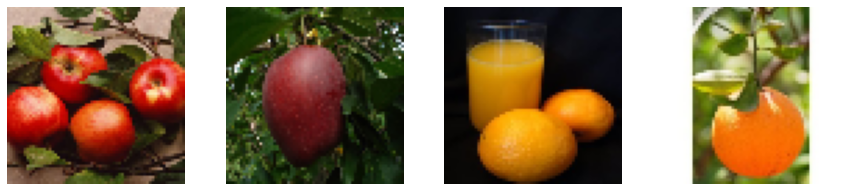

----------------------------------------------------------------------------------------------------
Real High quality version


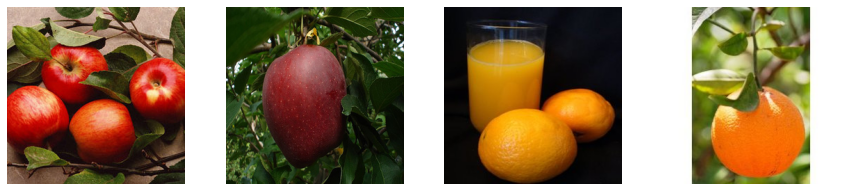

In [4]:
import cv2

files = np.random.choice(train, size=4)

print ("Low quality Samples")
for k in range(1):
    plt.figure(figsize=(15, 15))
    for j, file in enumerate(files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        plt.subplot(440 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*100)
print ("Real High quality version")
for k in range(1):
    plt.figure(figsize=(15, 15))
    for j, file in enumerate(files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(440 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (Resnet Like)

In [18]:
def custom_resnet_block(input_layer, filters, upsample=False, resnet=True):
    x = input_layer
    if resnet==True:
        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.Activation('relu')(x)
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

        # Skip Connection
        x = tensorflow.keras.layers.Add()([x, input_layer])
    
    if upsample==True:
        x = tensorflow.keras.layers.UpSampling2D(size=2)(x)
        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [19]:
low_quality_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))

first = tensorflow.keras.layers.Conv2D(64, kernel_size=9, strides=1, padding='same')(low_quality_image)
first = tensorflow.keras.layers.Activation('relu')(first)

x = custom_resnet_block(first, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

y = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
y = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(y)
y = tensorflow.keras.layers.Add()([y, first])

z = custom_resnet_block(y, 256, True, False)
z = custom_resnet_block(z, 256, True, False)

z = tensorflow.keras.layers.Conv2D(3, kernel_size=9, strides=1, padding='same')(z)
high_quality_image = tensorflow.keras.layers.Activation('tanh')(z)

In [20]:
generator_network = tensorflow.keras.models.Model(inputs=low_quality_image, outputs=high_quality_image)
print (generator_network.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 64, 64, 64)   15616       input_6[0][0]                    
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 64, 64, 64)   0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 64, 64, 64)   36928       activation_20[0][0]              
____________________________________________________________________________________________

# Discriminator Network

In [21]:
def custom_d_block(input_layer, filters, strides, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn==True:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [22]:
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

x = custom_d_block(high_quality_input, 64, 1, False)
x = custom_d_block(x, 64, 2, True)
x = custom_d_block(x, 128, 1, True)
x = custom_d_block(x, 128, 2, True)
x = custom_d_block(x, 256, 1, True)
x = custom_d_block(x, 256, 2, True)
x = custom_d_block(x, 512, 1, True)
x = custom_d_block(x, 512, 2, True)

x = tensorflow.keras.layers.Dense(1024)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

real_vs_fake_patch = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)

In [23]:
discriminator_network = tensorflow.keras.models.Model(inputs=high_quality_input, outputs=real_vs_fake_patch)
print (discriminator_network.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 128, 128, 128)     7385

In [24]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Pre Trained VGG feaures

In [25]:
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

pre_trained_vgg = tensorflow.keras.applications.VGG19(weights='imagenet', input_tensor=high_quality_input, include_top=False)
#pre_trained_vgg.outputs = [pre_trained_vgg.layers[9].output]

pre_trained_image_feautures = pre_trained_vgg(high_quality_input)

custom_vgg = tensorflow.keras.models.Model(inputs=high_quality_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________
None


# SR-GAN

In [26]:
low_quality_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

fake_high_quality_image = generator_network(low_quality_image)
fake_high_quality_features = custom_vgg(fake_high_quality_image)

discriminator_network.trainable=False
custom_vgg.trainable=False

d_output = discriminator_network(fake_high_quality_image)

sr_gan = tensorflow.keras.models.Model(inputs=[low_quality_image, high_quality_input],\
                                                   outputs=[d_output, fake_high_quality_features])

print (sr_gan.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 256, 256, 3)  2042691     input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            (None, 16, 16, 1)    5219137     model_4[0][0]                    
____________________________________________________________________________________________

# Compiling Models

In [27]:
sr_gan.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[0.001, 1], optimizer=adam_optimizer)

# Define Data Generators

In [28]:
def get_training_samples(batch_size):
    files = np.random.choice(train, size=batch_size)
    low_quality_images = []
    high_quality_images = []
    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img, (64, 64))
        low_quality_images.append((img2-127.5)/127.5)
        high_quality_images.append((img-127.5)/127.5)
    low_quality_images = np.array(low_quality_images)
    high_quality_images = np.array(high_quality_images)
    return low_quality_images, high_quality_images

def show_generator_results(generator_network):
    low_quality_images, high_quality_images = get_training_samples(3)
    fake_high_quality_images = generator_network.predict_on_batch(low_quality_images)

    print ("Low quality input images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((low_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ("Generated high quality images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((fake_high_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ("Real high quality images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((high_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

# Training GAN

In [29]:
len(train)

2014

Low quality input images


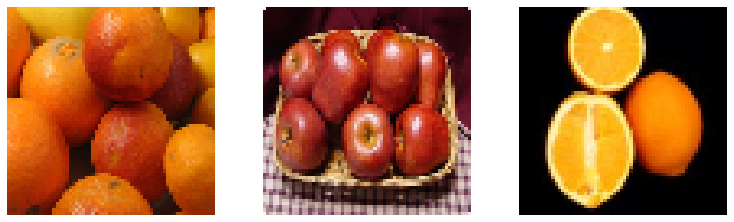

Generated high quality images


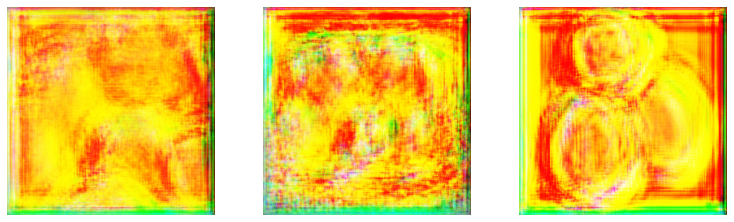

Real high quality images


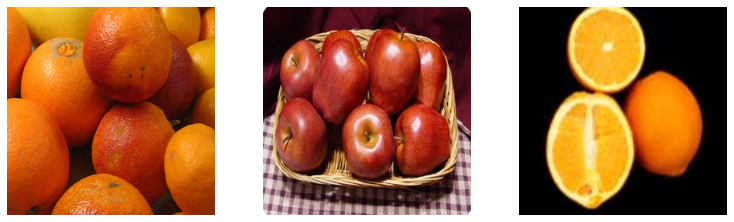

Epoch:0, Step:0, D-Loss:0.311, D-Acc:43.164, G-Loss:0.108
Epoch:0, Step:200, D-Loss:0.001, D-Acc:100.000, G-Loss:0.113
Epoch:0, Step:400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.114
Epoch:0, Step:600, D-Loss:0.000, D-Acc:100.000, G-Loss:0.094
Epoch:0, Step:800, D-Loss:0.000, D-Acc:100.000, G-Loss:0.054
Epoch:0, Step:1000, D-Loss:0.753, D-Acc:13.086, G-Loss:0.059
Epoch:0, Step:1200, D-Loss:0.081, D-Acc:88.086, G-Loss:0.083
Epoch:0, Step:1400, D-Loss:0.001, D-Acc:100.000, G-Loss:0.087
Epoch:0, Step:1600, D-Loss:0.001, D-Acc:100.000, G-Loss:0.058
Epoch:0, Step:1800, D-Loss:0.001, D-Acc:100.000, G-Loss:0.074
Low quality input images


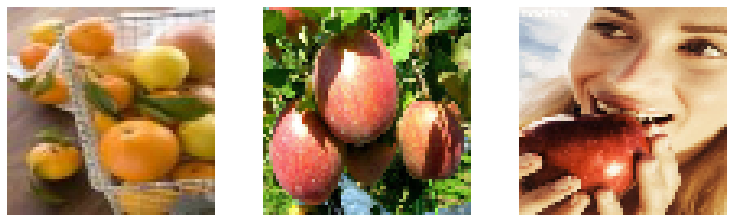

Generated high quality images


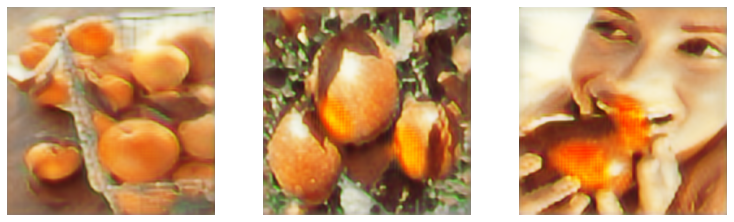

Real high quality images


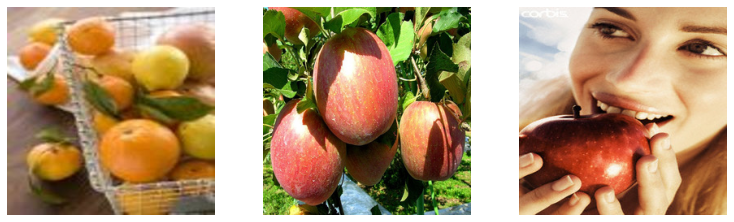

Epoch:1, Step:0, D-Loss:0.324, D-Acc:53.320, G-Loss:0.050
Epoch:1, Step:200, D-Loss:0.008, D-Acc:100.000, G-Loss:0.017
Epoch:1, Step:400, D-Loss:0.006, D-Acc:99.609, G-Loss:0.047
Epoch:1, Step:600, D-Loss:0.012, D-Acc:100.000, G-Loss:0.016
Epoch:1, Step:800, D-Loss:0.007, D-Acc:100.000, G-Loss:0.013
Epoch:1, Step:1000, D-Loss:0.177, D-Acc:64.648, G-Loss:0.021
Epoch:1, Step:1200, D-Loss:0.009, D-Acc:99.609, G-Loss:0.020
Epoch:1, Step:1400, D-Loss:0.002, D-Acc:100.000, G-Loss:0.056
Epoch:1, Step:1600, D-Loss:0.078, D-Acc:90.820, G-Loss:0.034
Epoch:1, Step:1800, D-Loss:0.002, D-Acc:100.000, G-Loss:0.037
Low quality input images


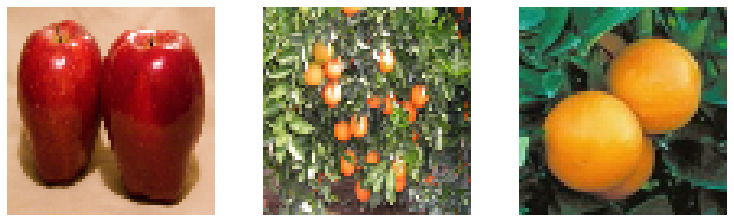

Generated high quality images


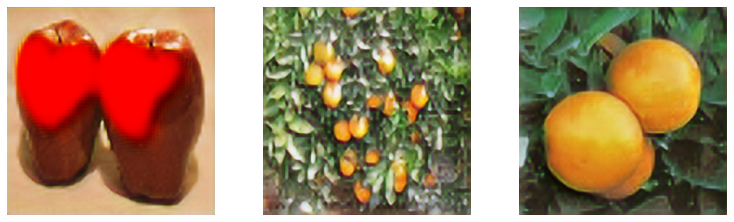

Real high quality images


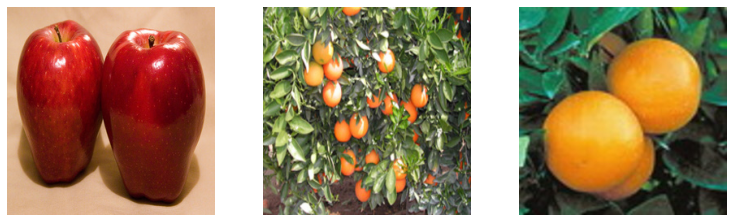

Epoch:2, Step:0, D-Loss:0.088, D-Acc:93.750, G-Loss:0.005
Epoch:2, Step:200, D-Loss:0.008, D-Acc:100.000, G-Loss:0.014
Epoch:2, Step:400, D-Loss:0.009, D-Acc:100.000, G-Loss:0.046
Epoch:2, Step:600, D-Loss:0.291, D-Acc:46.289, G-Loss:0.045
Epoch:2, Step:800, D-Loss:0.001, D-Acc:100.000, G-Loss:0.026
Epoch:2, Step:1000, D-Loss:0.013, D-Acc:99.805, G-Loss:0.020
Epoch:2, Step:1200, D-Loss:0.052, D-Acc:97.266, G-Loss:0.021
Epoch:2, Step:1400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.041
Epoch:2, Step:1600, D-Loss:0.000, D-Acc:100.000, G-Loss:0.035
Epoch:2, Step:1800, D-Loss:0.003, D-Acc:100.000, G-Loss:0.035
Low quality input images


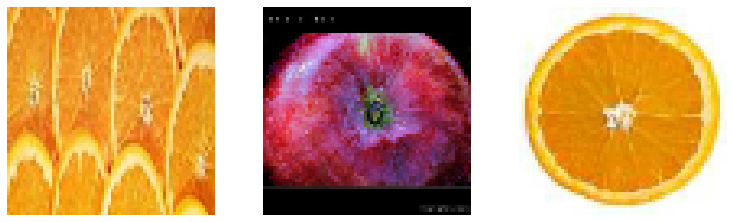

Generated high quality images


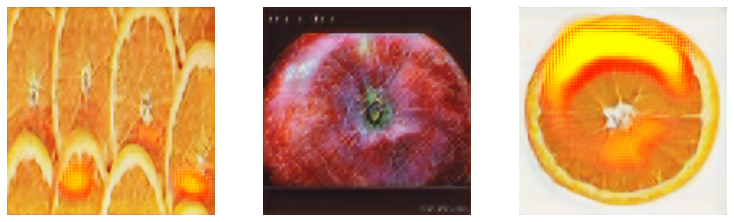

Real high quality images


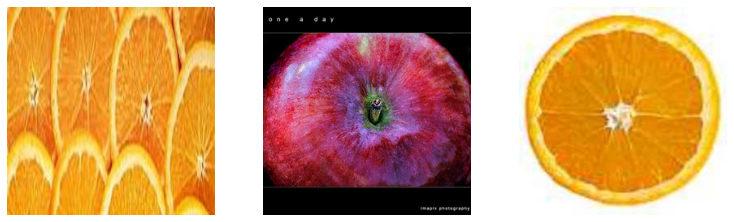

Epoch:3, Step:0, D-Loss:0.001, D-Acc:100.000, G-Loss:0.067
Epoch:3, Step:200, D-Loss:0.001, D-Acc:100.000, G-Loss:0.028
Epoch:3, Step:400, D-Loss:0.119, D-Acc:83.203, G-Loss:0.052
Epoch:3, Step:600, D-Loss:0.000, D-Acc:100.000, G-Loss:0.016
Epoch:3, Step:800, D-Loss:0.000, D-Acc:100.000, G-Loss:0.024
Epoch:3, Step:1000, D-Loss:0.004, D-Acc:99.805, G-Loss:0.032
Epoch:3, Step:1200, D-Loss:0.000, D-Acc:100.000, G-Loss:0.017
Epoch:3, Step:1400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.026
Epoch:3, Step:1600, D-Loss:0.000, D-Acc:100.000, G-Loss:0.029
Epoch:3, Step:1800, D-Loss:0.000, D-Acc:100.000, G-Loss:0.014
Low quality input images


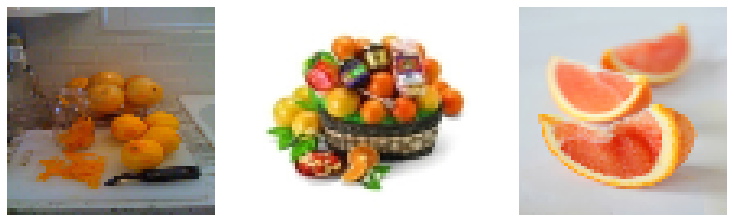

Generated high quality images


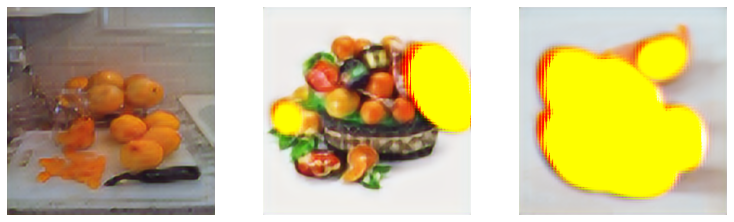

Real high quality images


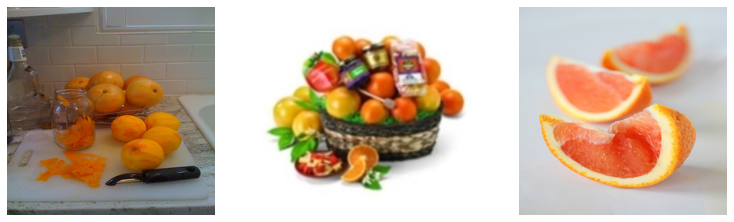

Epoch:4, Step:0, D-Loss:0.001, D-Acc:100.000, G-Loss:0.005
Epoch:4, Step:200, D-Loss:0.000, D-Acc:100.000, G-Loss:0.047
Epoch:4, Step:400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.086
Epoch:4, Step:600, D-Loss:0.000, D-Acc:100.000, G-Loss:0.062
Epoch:4, Step:800, D-Loss:0.000, D-Acc:100.000, G-Loss:0.022
Epoch:4, Step:1000, D-Loss:0.000, D-Acc:100.000, G-Loss:0.058
Epoch:4, Step:1200, D-Loss:0.002, D-Acc:100.000, G-Loss:0.045


KeyboardInterrupt: ignored

In [30]:
epochs = 500
batch_size = 1
steps = 2000

for i in range(0, epochs):
    if (i%1 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        low_quality_images, high_quality_images = get_training_samples(batch_size)

        fake_high_quality_images = generator_network.predict_on_batch(low_quality_images)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(high_quality_images, real_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_high_quality_images, fake_patch)
        loss_d = np.add(loss_d_real, loss_d_fake)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        low_quality_images, high_quality_images = get_training_samples(batch_size)
        discriminator_network.trainable=False

        real_vgg_features = custom_vgg.predict_on_batch(high_quality_images)

        # Updating Generator weights
        loss_g = sr_gan.train_on_batch([low_quality_images, high_quality_images], [real_patch, real_vgg_features])
        
        if j%200 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))